## 용접 품질 검사
### 딥러닝을 통한 용접 품질 검사 실습은 아래와 같은 순서로 진행합니다.
1. 1장의 원본 이미지에 노이즈를 추가하여 다양한 노이즈들을 가진 데이터셋을 생성합니다.
2. 생성된 데이터셋을 통해 CNN 모델을 생성합니다.
3. 생성된 CNN 모델을 활용하여 MODI 모듈을 동작시킵니다.

In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

### 원본 이미지 확인

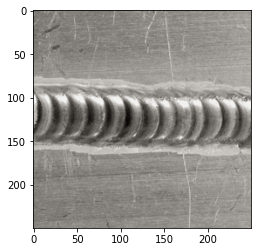

In [2]:
image = cv2.imread('./data/weld1.jpeg')
plt.imshow(image)

### 노이즈 데이터 추가

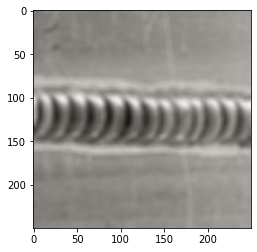

In [3]:
# 블러 - 실행할 때마다 랜덤 숫자를 생성하여 그 수치 만큼 블러를 넣습니다.
def blur(image):
    filtersize = random.randrange(3,11)
    low_pass_filter = np.ones((filtersize, filtersize), np.float32) / filtersize**2
    dst = cv2.filter2D(image, -1, low_pass_filter)
    return dst

blur_image = blur(image)
plt.imshow(blur_image)

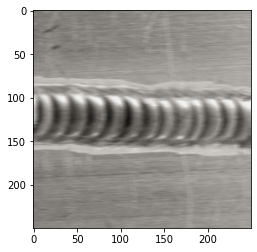

In [4]:
# 모션 블러 - 실행할 때마다 랜덤 숫자를 생성하여 움직이는 듯한 블러 효과를 줍니다.
def motion_blur(image):
    size = random.randrange(5,15)
    motion_blur = np.zeros((size, size))
    motion_blur[int((size-1)/2), :] = np.ones(size)
    motion_blur = motion_blur / size
    dst = cv2.filter2D(image, -1, motion_blur)
    
    return dst

motion_image = motion_blur(image)
plt.imshow(motion_image)

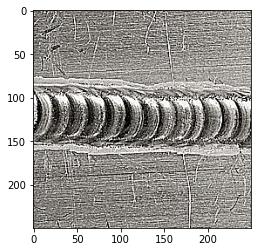

In [5]:
# 샤프닝 - 실행할 때마다 랜덤 숫자를 생성하여 샤프닝 효과를 줍니다.
def sharpening(image):
    rand = random.randrange(1,4)
    if rand == 1:
        mask = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    elif rand == 2:
        mask = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    else:
        mask = np.array([[-1, -1, -1, -1, -1],
                         [-1, 2, 2, 2, -1],
                         [-1, 2, 9, 2, -1],
                         [-1, 2, 2, 2, -1],
                         [-1, -1, -1, -1, -1]]) / 9.0
    dst = cv2.filter2D(image, -1, mask)
    return dst

sharpening_image = sharpening(image)
plt.imshow(sharpening_image)

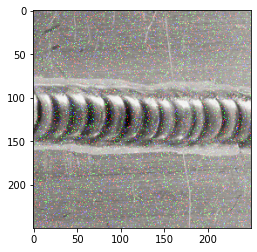

In [6]:
# 가우시안 노이즈 - 실행할 때마다 랜덤 숫자를 생성하여 가우시안 노이즈를 추가합니다.
def gaussian_noise(image):
    rand = random.randrange(0,11)*0.1+0.5
    gauss = np.random.normal(0,rand,image.size)
    gauss = gauss.reshape(image.shape[0],image.shape[1],image.shape[2]).astype('uint8')
    # Add the Gaussian noise to the image
    image_gauss = cv2.add(image,gauss)
    return image_gauss
gaussian_image = gaussian_noise(image)
plt.imshow(gaussian_image)

### 노이즈 데이터 생성
위에서 확인한 노이즈 생성 모듈을 사용하여, 정상-비정상 데이터셋을 생성합니다.

In [7]:
# 위에서 확인한 노이즈 생성 함수들을 랜덤으로 호출하여 노이즈 데이터를 생성하고, 동일한 개수의 원본 데이터를 복제하여 데이터셋을 생성합니다.
def generate_data(number):
    duplicated_original_images = []
    noise_images = []
    data = []
    label = []
    for i in range(number):
        idx = random.randrange(1,5)
        if idx == 1:
            img = blur(image)
        elif idx == 2:
            img = motion_blur(image)
        elif idx == 3:
            img = sharpening(image)
        else:
            img = gaussian_noise(image)
        
        duplicated_original_images.append(image)
        noise_images.append(img)
        data.append(image)
        label.append(0)
        data.append(img)
        label.append(1)
    return duplicated_original_images, noise_images, np.array(data), np.array(label)

normal, abnormal, data, label = generate_data(200) # 정상/불량 데이터를 각 200개씩 생성합니다.

### 생성한 데이터셋(정상 - 비정상) 중 각 5개씩만 출력해봅니다.

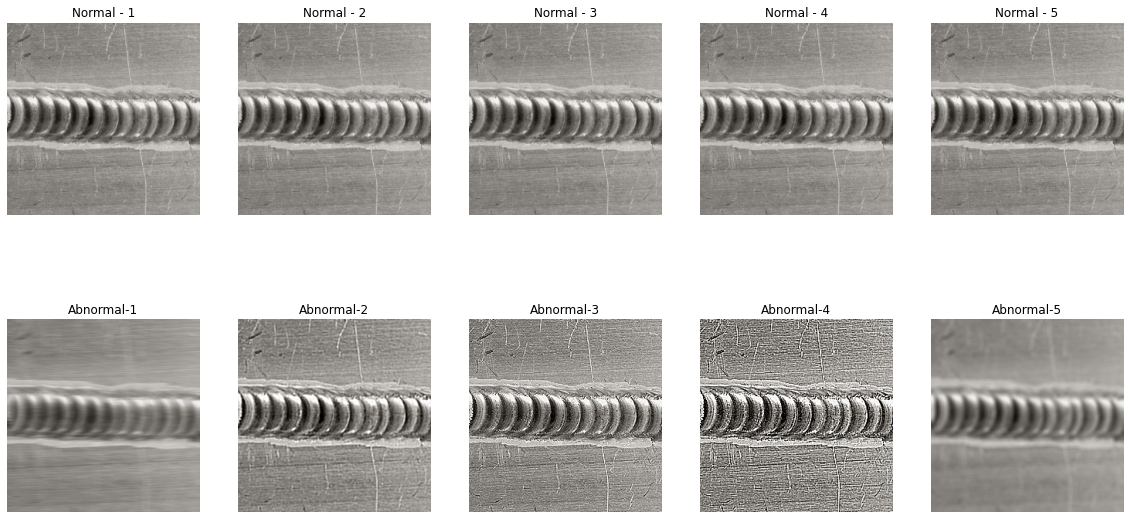

In [8]:
fig = plt.figure(figsize=(20,10))
rows = 2
cols = 5

for i in range(5): # 정상 데이터 5개 출력
    ax = fig.add_subplot(rows,cols,i+1)
    ax.imshow(normal[i])
    ax.set_title("Normal - "+ str(i+1))
    ax.axis("off")
    
for i in range(5): # 비정상 데이터 5개 출력
    ax = fig.add_subplot(rows,cols,i+6)
    ax.imshow(abnormal[i])
    ax.set_title("Abnormal-"+ str(i+1))
    ax.axis("off")
 
plt.show()


## CNN 모델 학습

#### 모듈 import 및 버전, 데이터 확인

In [9]:
# 학습 모델 생성을 위해 Tensorflow 및 Keras를 import 합니다.
import tensorflow as tf
from tensorflow import keras

In [10]:
print(tf.__version__) # tf version check

2.4.0-rc0


In [11]:
data.shape # data shape 확인 : 400개의 데이터, 가로 250픽셀, 세로 250픽셀, 3채널(컬러RGB)

(400, 250, 250, 3)

In [12]:
label.shape # label shape 확인 : label은 0 또는 1 데이터만 가지고 있기 때문에 shape는 400

(400,)

#### 데이터 분할( Train, Test, Validate Set을 4:3:3 비율로 분할)

In [13]:
num_data = len(data)
print("전체 데이터 개수 : ", num_data)
inputs_train, inputs_test, inputs_validate = np.split(data, [int(num_data*0.4), int(num_data*0.7)])
outputs_train, outputs_test, outputs_validate = np.split(label, [int(num_data*0.4), int(num_data*0.7)])

전체 데이터 개수 :  400


In [14]:
print("Train Set : ",inputs_train.shape)
print("Test Set : ",inputs_test.shape)
print("Validate Set : ",inputs_validate.shape)

Train Set :  (160, 250, 250, 3)
Test Set :  (120, 250, 250, 3)
Validate Set :  (120, 250, 250, 3)


#### 모델 Layer 구성

In [15]:
model = tf.keras.Sequential() # keras layer를 구성하기 위해 Sequential을 선언합니다.
# 컨볼루션 레이어에서느 3by3 커널 32개를 사용하고, 인풋 사이즈를 이미지 사이즈인 (250,250,3)으로 맞춥니다. activation function으로는 relu를 사용합니다.
model.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(250,250,3), activation='relu')) 
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2))) # Max 풀링 레이어를 추가합니다.
model.add(tf.keras.layers.Flatten()) # Flatten 레이어를 추가합니다.
model.add(tf.keras.layers.Dense(units=100, activation='relu')) # Dense 레이어를 추가합니다. 출력 Units 개수는 100개로 설정합니다.
# 정상/불량의 Binary Classification을 위해 마지막 Dense 레이어는 출력 Units 개수를 1로 하고 activation function을 sigmoid로 설정합니다.
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) 

In [16]:
model.summary() # 작성한 모델을 확인해봅니다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 492032)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               49203300  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 49,204,297
Trainable params: 49,204,297
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy']) # 모델 파라미터들을 설정합니다.

In [18]:
# 모델 학습을 시작합니다. epoch별 accuracy가 상승하는 것을 확인합니다.
hist = model.fit(inputs_train, outputs_train, validation_data = (inputs_test, outputs_test), epochs = 10, batch_size = 10)

Epoch 1/10
16/16 [==============================] - 4s 230ms/step - loss: 4514.0498 - accuracy: 0.4385 - val_loss: 913.5626 - val_accuracy: 0.5000
Epoch 2/10
16/16 [==============================] - 5s 312ms/step - loss: 478.3541 - accuracy: 0.5906 - val_loss: 139.6608 - val_accuracy: 0.5000
Epoch 3/10
16/16 [==============================] - 4s 246ms/step - loss: 51.2844 - accuracy: 0.6915 - val_loss: 9.3184 - val_accuracy: 0.8167
Epoch 4/10
16/16 [==============================] - 3s 207ms/step - loss: 4.0562 - accuracy: 0.9072 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 3s 207ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 3s 209ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 3s 208ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.

## 모델 성능 테스트
### 생성된 모델에 5개의 validation 데이터를 넣어 확인해봅니다.
- 0은 노이즈가 없는 원본, 1은 노이즈가 있음을 의미합니다.
- 모델을 통해 출력된 예측값(Predict)과 실제값(Label)이 일치함을 확인할 수 있습니다.

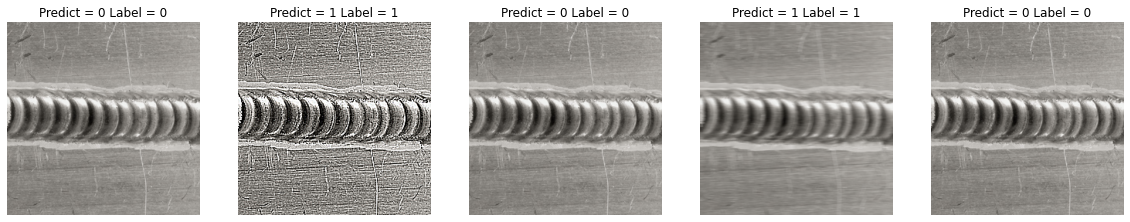

In [19]:
fig = plt.figure(figsize=(20,5))
rows = 1
cols = 5

for i in range(5): # 정상 데이터 5개 출력
    ax = fig.add_subplot(rows,cols,i+1)
    input_image = inputs_validate[i]
    label = outputs_validate[i]
    ax.imshow(input_image)
    reshape_image = input_image.reshape(-1,250,250,3)
    pred = model.predict(reshape_image)
    pred = int(pred[0][0])
    ax.set_title("Predict = " + str(pred) + " Label = "+ str(label))
    ax.axis("off")
    
plt.show()

## MODI 연동
- 랜덤으로 이미지를 추출하여 정상 이미지일 때는 초록색, 노이즈가 포함된 이미지일 때는 빨간색 LED가 켜지도록 합니다.

In [ ]:
import modi

bundle = modi.MODI()
led = bundel.leds[0]

- 키보드 control 키를 누른 상태에서 Enter 키를 천천히 반복해서 눌러 이미지별 예측 결과와 LED 모듈의 색깔 변화를 확인합니다.

In [ ]:
rand = random.randrange(0,len(inputs_validate))
im = inputs_validate[rand]
plt.imshow(im)
reshape_image = im.reshape(-1,250,250,3)
pred = model.predict(reshape_image)
pred = int(pred[0][0])

if pred == 0:
#     led.green = 100
    print("예측 결과 : 정상")
elif pred == 1:
#     led.red = 100
    print("예측 결과 : 불량")
